# Below is the colab directory of Boston Housing dataset related programs.

## Task 1: Acquire, preprocess, and analyze the data

### Read the CSV

In [223]:
import pandas as pd
import numpy as np
import csv

url = "http://lib.stat.cmu.edu/datasets/boston"

# the given url is hard to work with. I found a 'better' link:
better_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"

column_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE', 'DIS', 'RAD', 'TAX',
    'PTRATIO', 'B', 'LSTAT', 'MEDV'
]

boston_df = pd.read_csv(better_url, names=column_names, sep='\s+', header=None)
# drop the problematic column
boston_df = boston_df.drop(columns=['B'])
display(boston_df)

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1    0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2    0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3    0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4    0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273.0   
502  0.04527   0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273.0   
503  0.06076   0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273.0   
504  0.10959   0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273.0   
505  0.04741   0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273.0   

     PTRATIO  LSTAT  MEDV  
0       15.3   4.98  24.0  
1       17.8   9.14  21.6  
2       17.8   4.03  34.7  
3       18.7   2.94  33.4  
4       18.7   5.33  36.2  
..       ...    ...   ...  
501     21.0   9.67  22.4  
502     21.0   9.08  20.6  
503     21.0   5.64  23.9  
504     21.0   6.48  22.0  
505     21.0   7.88  11.9  

[506 rows x 13 columns]

### Checking the missing values

In [224]:
missing_values = boston_df.isnull().any(axis=1)
missing_data = boston_df[missing_values]

miss_ques = boston_df.eq('?').any(axis = 1)
missing_data_q = boston_df[miss_ques]
print(missing_data)
print(missing_data_q)

Empty DataFrame
Columns: [CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT, MEDV]
Index: []
Empty DataFrame
Columns: [CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT, MEDV]
Index: []


### Dataset statistics rendering

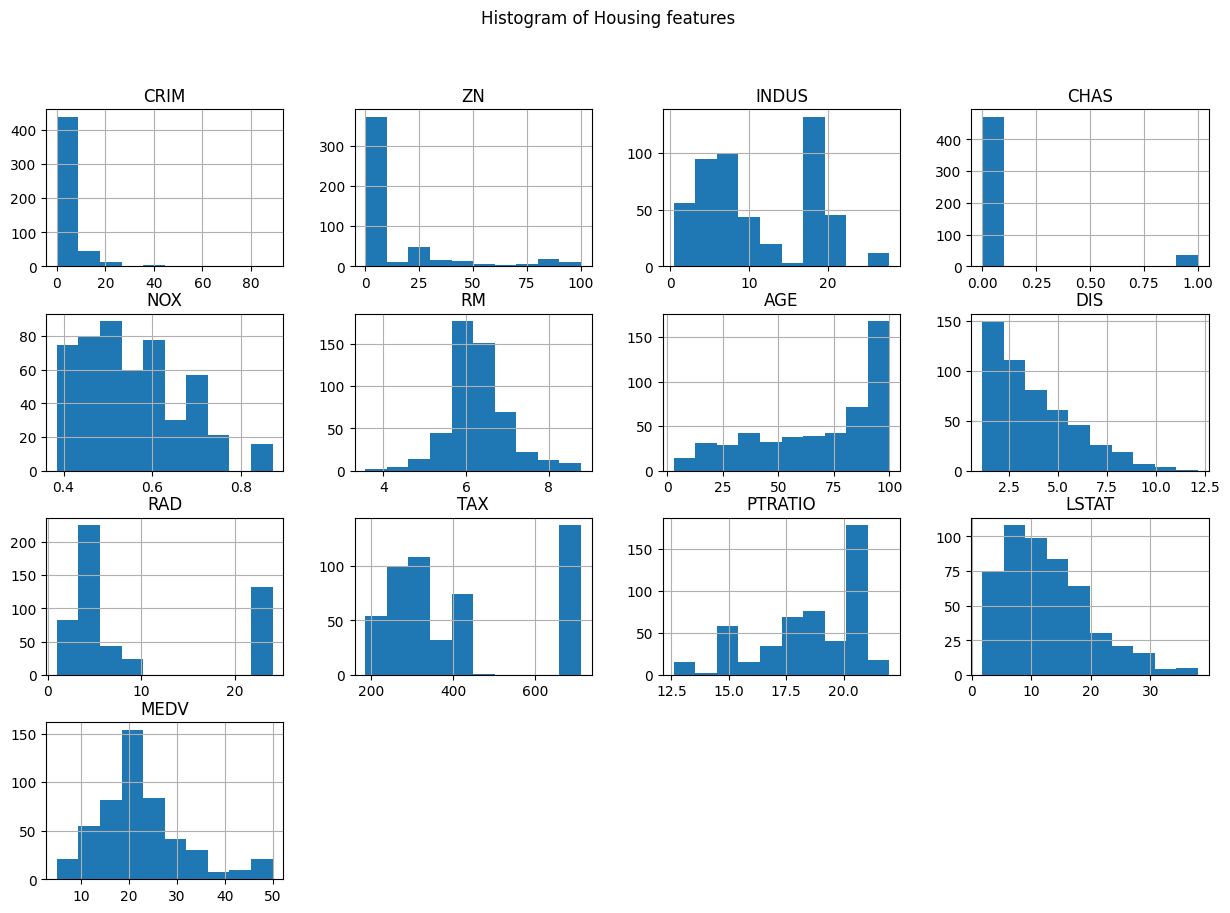

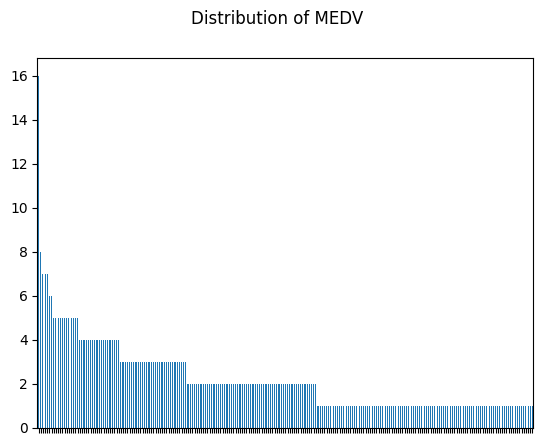

In [225]:
import matplotlib.pyplot as plt

numerical_summary = boston_df.describe()
class_distribution = boston_df['MEDV'].value_counts()
boston_df.hist(figsize=(15, 10))
plt.suptitle('Histogram of Housing features')
plt.show()

subplot = class_distribution.plot(kind='bar')
subplot.axes.set_xticklabels([])
plt.suptitle('Distribution of MEDV')
plt.show()

## Task 2: Implement the models

### Model Implementation

In [226]:
import numpy as np

x_set = boston_df.drop('MEDV', axis=1).values
y_set = boston_df['MEDV'].values
print(x_set.shape)
print(y_set.shape)

(506, 12)
(506,)


In [227]:
class LinearRegression:
    def __init__(self, option="Analytical", lr=0.001, max_epoch=5000, epsilon=0.01, batchsize=32, momentum=0, seed=42,s=1, use_gauss = False):
        assert option == "Analytical" or option == "SGD", "wrong parameter for option"
        # options: analytic / SGD
        self.option = option
        self.lr = lr
        self.max_epoch = max_epoch
        self.epsilon = epsilon
        self.batchsize = batchsize
        self.momentum = momentum
        self.seed = seed
        self.s = s
        self.centers = None
        self.use_gauss = use_gauss
        self.num_gaussians = 5

    def data_preprocess(self, x, y):
        # perform data normalization (for each row)
        try:
            x_normalized = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
        except RuntimeWarning:
            print(np.std(x, axis=0))
        # add a bias column
        x_normalized = np.insert(x_normalized, 0, 1, axis=1)
        return x_normalized, y

    def param_init(self, x_normalized):
        # set seed and initialize w
        np.random.seed(self.seed)
        N, D = x_normalized.shape           # N: number of samples, D: number of features
        self.w = np.random.rand(D)          # Initialize weights (including bias)
                                            # w: D x 1 column vector
    def fit(self, x, y):
        # x: design matrix, N x D; y: dependent variable: N x 1
        # first preprocess the data, initialized w
        x_normalized, y = self.data_preprocess(x, y)
        self.param_init(x_normalized)
        N, D = x_normalized.shape

        # only for SGD:
        gradient_norm_per_step = []
        loss_per_step = []
        delta = np.zeros(D)

        if self.option == "Analytical" and self.use_gauss == False:
            self.w = np.linalg.inv(x_normalized.T @ x_normalized) @ x_normalized.T @ y
        elif self.option == "Analytical" and self.use_gauss == True:
            self.w = np.linalg.pinv(x_normalized.T @ x_normalized) @ x_normalized.T @ y
        else:
            for epoch in range(self.max_epoch):
                indices = np.random.permutation(N)
                x_shuffled = x_normalized[indices]
                y_shuffled = y[indices]
                for i in range(0, N, self.batchsize):
                    x_mini_batch = x_shuffled[i:i + self.batchsize]        # B x D
                    y_mini_batch = y_shuffled[i:i + self.batchsize]        # B x 1

                    predictions = x_mini_batch @ self.w                    # B x 1
                    errors = predictions - y_mini_batch                    # B x 1
                    gradient = x_mini_batch.T @ errors / self.batchsize    # D x 1
                    gradient_norm_per_step.append(np.linalg.norm(gradient))
                    loss = self.calculate_loss(y_mini_batch, predictions)
                    loss_per_step.append(loss)
                    delta = self.momentum * delta + (1 - self.momentum) * gradient
                    self.w = self.w - self.lr * delta
        return gradient_norm_per_step, loss_per_step

    def predict(self, x):
        x_normalized, _ = self.data_preprocess(x, 0)
        y_pred = x_normalized @ self.w
        return y_pred

    def calculate_loss(self, y, predictions):
        # loss is just MSE here. Note that statistical definition of MSE requires division by N-2 (so it's unbiased estimator of variance)
        # here we divide by N
        N = y.shape
        errors = predictions - y
        return 0.5 * np.sum(np.multiply(errors, errors)) / N

    def cross_validate(self, x, y, k=5):
        assert k > 1
        fold_size = len(y) // k
        indices = np.random.permutation(len(y))

        metric_record = []
        for i in range(k):
            # Define the validation fold
            val_indices = indices[i * fold_size: (i+1) * fold_size]
            train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])

            x_train, y_train = x[train_indices], y[train_indices]
            x_val, y_val = x[val_indices], y[val_indices]

            # Train the model on the training folds
            self.fit(x_train, y_train)

            # Predict on the validation fold
            y_pred = self.predict(x_val)

            # Calculate metrics on the validation fold
            metrics = self.calculate_loss(y_val, y_pred)
            metric_record.append(metrics)

        return np.mean(metric_record)

### Some helper functions for benchmarking

In [228]:
def dataset_split(x, y, test_size=0.2, random_state=True):
    if random_state:
        np.random.seed(random_state)
    assert len(x) == len(y)
    cut_point = np.random.permutation(len(x))
    test_size = int(len(x) * test_size)
    test_indices = cut_point[:test_size]
    train_indices = cut_point[test_size:]
    return x[train_indices], x[test_indices], y[train_indices], y[test_indices]

def test_with_param_splitted(x_train, x_test, y_train, y_test, train_percentage=0.8, option="Analytical", max_epoch=1000, batchsize=32, learning_rate=0.001, momentum=0,use_gauss = True):
    model = LinearRegression(option=option, lr=learning_rate, batchsize=batchsize, max_epoch=max_epoch, momentum=momentum, use_gauss=use_gauss)
    grad, train_loss = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    test_loss = model.calculate_loss(y_test, y_pred)
    return grad, train_loss, test_loss

def test_with_param(x, y, train_percentage=0.8, option="Analytical", max_epoch=1000, batchsize=32, learning_rate=0.001, momentum=0, use_gauss = True):
    x_train, x_test, y_train, y_test = dataset_split(x, y, test_size=1-train_percentage)
    return test_with_param_splitted(x_train, x_test, y_train, y_test, train_percentage=train_percentage, option=option, batchsize=batchsize, max_epoch=max_epoch, learning_rate=learning_rate, momentum=momentum,use_gauss = use_gauss)

def cross_validate(x, y, k=5, option="Analytical", max_epoch=1000, batchsize=32, learning_rate=0.001, momentum=0):
    assert k > 1
    fold_size = len(y) // k
    indices = np.random.permutation(len(y))

    grads = []
    train_loss = []
    test_loss = []

    for i in range(k):
        val_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])

        x_train, y_train = x[train_indices], y[train_indices]
        x_val, y_val = x[val_indices], y[val_indices]
        grad, train, test = test_with_param_splitted(x_train, x_val, y_train, y_val, max_epoch=max_epoch, option=option, batchsize=batchsize, learning_rate=learning_rate, momentum=momentum)

        grads.append(grad)
        train_loss.append(train)
        test_loss.append(test)
    return np.mean(grads, axis=0), np.mean(train_loss, axis=0), np.mean(test_loss)

## Task 3: Run experiments

### Subtask 3.1: Report the metrics under an 80/20 train/test split

Test loss of analytical linear regression is: [12.01265457]
Test loss of linear regression with SGD is: [12.23696162]


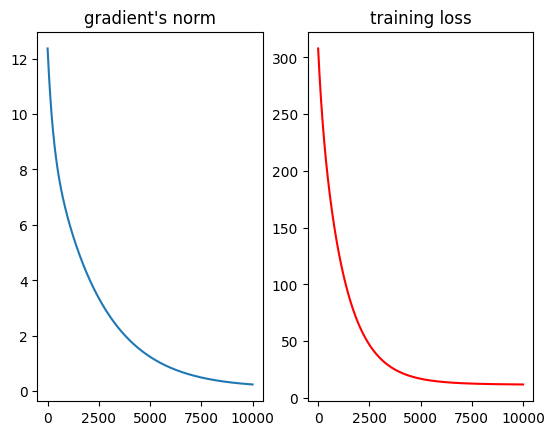

In [229]:
# with analytical linear regression
print("Test loss of analytical linear regression is: {0}".format(test_with_param(x_set, y_set)[2]))

# with SGD
grad, train, test = test_with_param(x_set, y_set, option="SGD", max_epoch=10000, batchsize=1000)
print("Test loss of linear regression with SGD is: {0}".format(test))
plt.subplot(1, 2, 1)
plt.title("gradient's norm")
plt.plot(grad)
plt.subplot(1, 2, 2)
plt.title("training loss")
plt.plot(train, color="red")
plt.show()

# one can see that the losses of the two method are basically the same
# why larger batchsize requires more iterations to converge??

### Subtask 3.2: Test the performance of model using cross-validation

Test loss of analytical linear regression is: 12.803416065952756
Test loss of linear regression with SGD is: 13.25906425328478


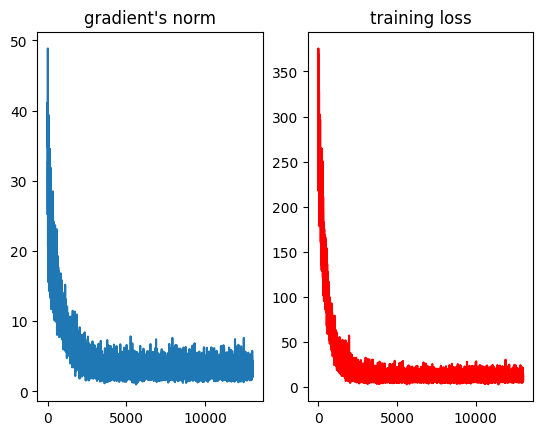

In [230]:
# with analytical linear regression
print("Test loss of analytical linear regression is: {0}".format(cross_validate(x_set, y_set)[2]))

# with SGD
grad, train, test = cross_validate(x_set, y_set, option="SGD", max_epoch=1000)
print("Test loss of linear regression with SGD is: {0}".format(test))
plt.subplot(1, 2, 1)
plt.title("gradient's norm")
plt.plot(grad)
plt.subplot(1, 2, 2)
plt.title("training loss")
plt.plot(train, color="red")
plt.show()

# one can see again that the performances are similar

### Subtask 3.3: Test the performance of model given different training set size

<ipython-input-227-2b6fccc3dfc2>:20: RuntimeWarning: invalid value encountered in divide
  x_normalized = (x - np.mean(x, axis=0)) / np.std(x, axis=0)


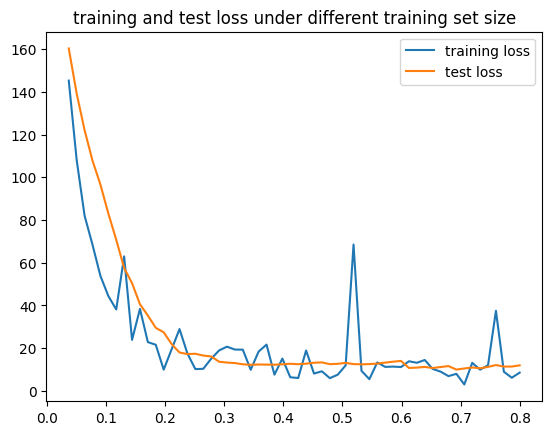

In [231]:
percentage_of_training = np.linspace(0.01, 0.8, num=60)
loss_on_train = []
loss_on_test = []
for p in percentage_of_training:
    _, train, test = test_with_param(x_set, y_set, train_percentage=p, max_epoch=1000, option="SGD", batchsize=64)
    loss_on_train.append(train[len(train) - 1])
    loss_on_test.append(test)

plt.plot(percentage_of_training, loss_on_train, label="training loss")
plt.plot(percentage_of_training, loss_on_test, label="test loss")
plt.legend(loc="upper right")
plt.title("training and test loss under different training set size")
plt.show()

### Subtask 3.4: Test of convergence speed and performance of different batch sizes (SGD)

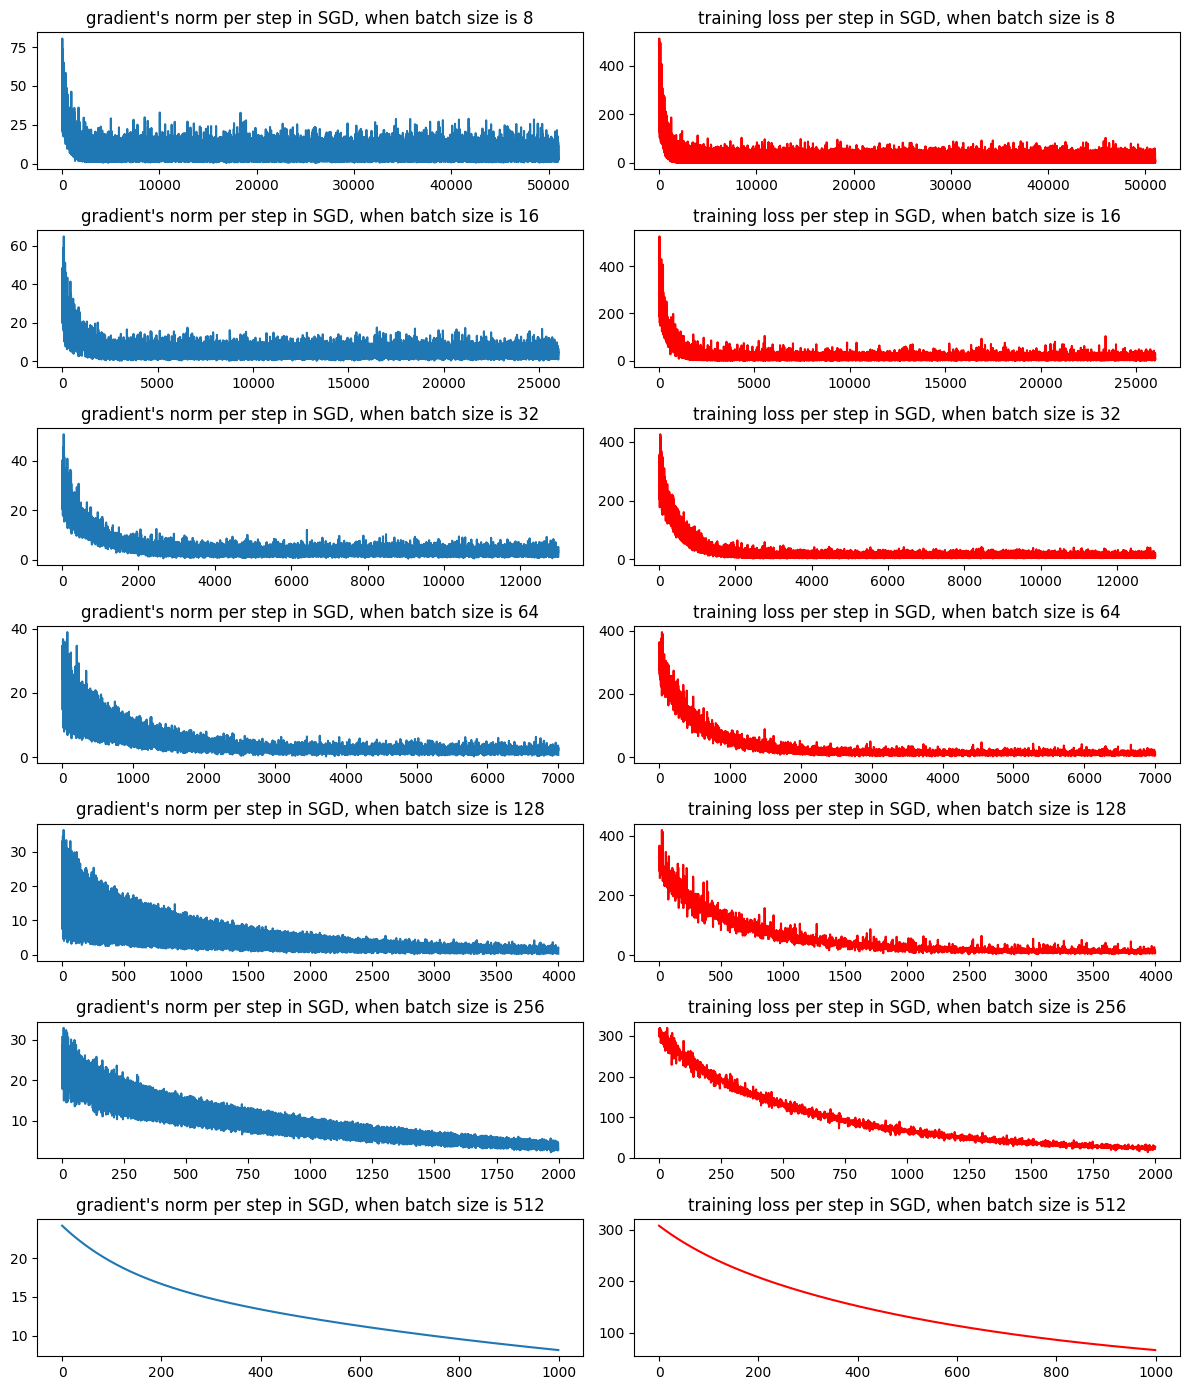

In [232]:
batchsizes = [2 ** i for i in range(3, 10)]
num_batches = len(batchsizes)
plt.figure(figsize=(12, 2 * num_batches))

for idx, b in enumerate(batchsizes):
    gradient, train, test = test_with_param(x_set, y_set, option="SGD", max_epoch=1000, batchsize=b)

    plt.subplot(num_batches, 2, 2 * idx + 1)
    plt.plot(gradient)
    plt.title("gradient's norm per step in SGD, when batch size is {0}".format(b))

    plt.subplot(num_batches, 2, 2 * idx + 2)
    plt.plot(train, color="red")
    plt.title("training loss per step in SGD, when batch size is {0}".format(b))

plt.tight_layout()
plt.show()

### Subtask 3.5: Test of performance under different learning rates

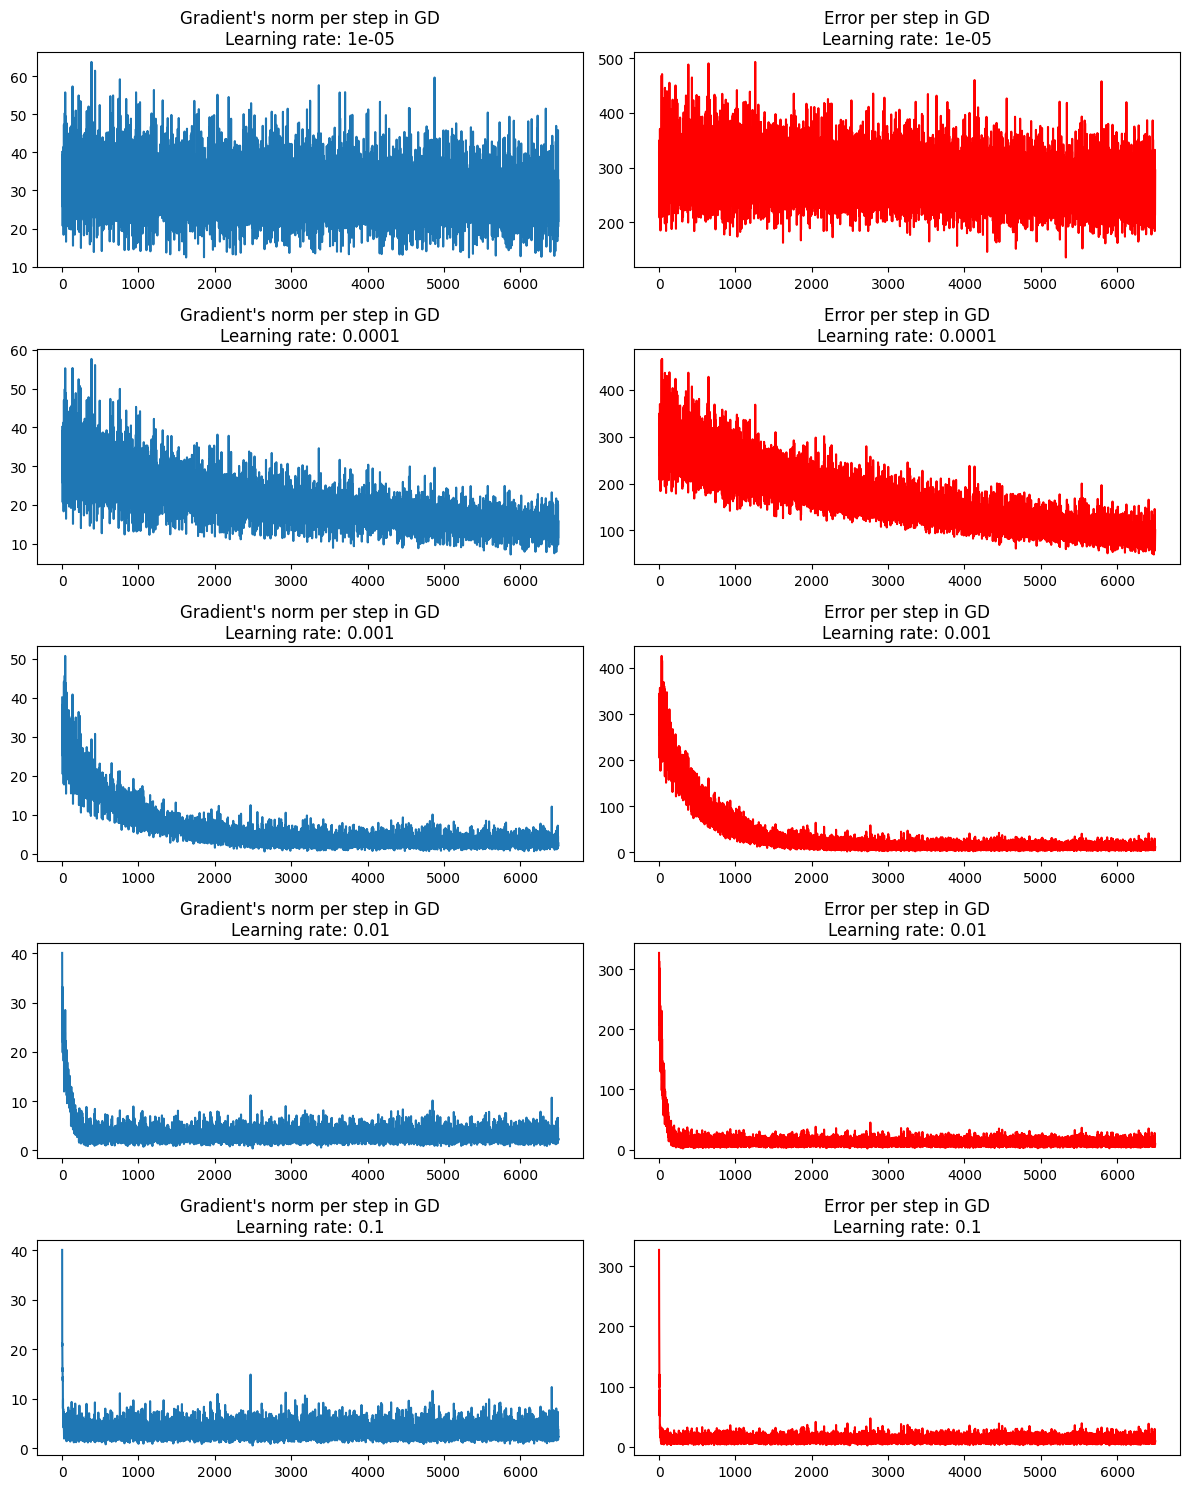

In [233]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
num_lrs = len(learning_rates)
fig, axes = plt.subplots(num_lrs, 2, figsize=(12, 3 * num_lrs))

for idx, lr in enumerate(learning_rates):
    gradient, train, test = test_with_param(x_set, y_set, option="SGD", max_epoch=500, learning_rate=lr)
    axes[idx, 0].plot(gradient)
    axes[idx, 0].set_title("Gradient's norm per step in GD\nLearning rate: {0}".format(lr))
    axes[idx, 1].plot(train, color="red")
    axes[idx, 1].set_title("Error per step in GD\nLearning rate: {0}".format(lr))
plt.tight_layout()
plt.show()

### Subtask 3.6: Select approriate metric and choose optimal parameter based on the metric

In [234]:
# add a table for parameter performances...
# batchsize and learning rate
# Use test loss as the metric:
from prettytable import PrettyTable

batchsizes = np.array([2 ** i for i in range(3, 10)])
learning_rates = np.array([0.00001, 0.0001, 0.001, 0.01, 0.1])

tests = np.zeros((len(batchsizes), len(learning_rates)))
for i, b in enumerate(batchsizes):
    for j, lr in enumerate(learning_rates):
        _, _, test = test_with_param(x_set, y_set, option="SGD", batchsize=b, learning_rate=lr)
        tests[i, j] = test

testtable = PrettyTable()
testtable.field_names = ["", "1e-5", "1e-4", "0.001", "0.01", "0.1"]
for i, r in enumerate(tests):
    t_list = [batchsizes[i]] + r.tolist()
    testtable.add_row(t_list)
print(testtable)

# considering metrics shown in below table, we take batchsize=8, learning_rate=0.1 as the best parameter

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|     |        1e-5        |        1e-4        |       0.001        |        0.01        |        0.1         |
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|  8  | 113.96764356870794 | 12.039005883931262 | 12.02006711278341  | 11.877045149124882 | 11.001362419690958 |
|  16 | 180.73736873737263 | 14.511949685191128 | 12.047995422702867 | 11.967858768848247 | 11.088525345624173 |
|  32 | 233.71435096596463 | 35.84242182182129  | 12.021454091228454 | 12.002385650062678 | 11.523745768484318 |
|  64 | 270.52123032595676 | 91.70837136936584  | 11.980251329424599 | 12.014122807724007 | 11.81521614442933  |
| 128 | 293.3712673812693  | 160.3678436000892  | 12.906612124610547 | 12.039834496005291 | 11.982728213454815 |
| 256 | 306.3305499420601  | 218.44129006039557 | 25.251186961232207 | 12.040878087760165 | 12.0

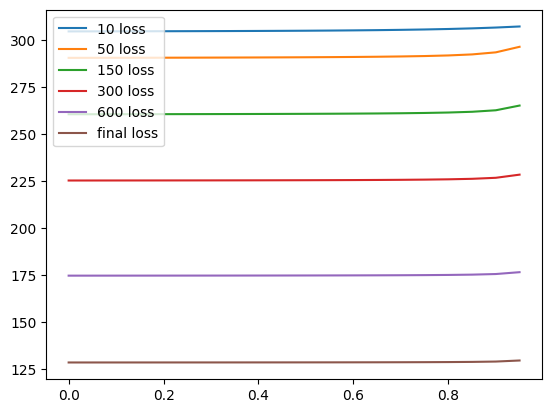

In [235]:
# clearly here MSE is the only metric suitable for and we should use it
# test momentum:

beta = np.linspace(0, 0.95, 20)
train_loss_on_10 = []
train_loss_on_50 = []
train_loss_on_150 = []
train_loss_on_300 = []
train_loss_on_600 = []
final_train_loss = []
totaltrain = []
for b in beta:
    _, train, test = test_with_param(x_set, y_set, option="SGD", max_epoch=1000, batchsize=1000, momentum=b)
    totaltrain.append(train)
    train_loss_on_10.append(train[9])
    train_loss_on_50.append(train[49])
    train_loss_on_150.append(train[149])
    train_loss_on_300.append(train[299])
    train_loss_on_600.append(train[599])
    final_train_loss.append(train[999])

plt.plot(beta, train_loss_on_10, label="10 loss")
plt.plot(beta, train_loss_on_50, label="50 loss")
plt.plot(beta, train_loss_on_150, label="150 loss")
plt.plot(beta, train_loss_on_300, label="300 loss")
plt.plot(beta, train_loss_on_600, label="600 loss")
plt.plot(beta, final_train_loss, label="final loss")
plt.legend(loc="upper left")
plt.show()

# again adding momentum has nearly no impact
# the choice of optimal parameter:
# Analytical is better than SGD (?)
# if use SGD, learning_rate = 0.01, momentum = 0, batchsize = 256/512

### Subtask 3.7: Test the performance of model after adding Gaussian Basis (Analytical)

In [237]:
# ???
import random

def gaussian(x, mu):
    return np.exp(-0.5 * (x - mu) ** 2)

N, D = x_set.shape
x_0 = x_set[:, 0]
indices = [random.randint(0, N-1) for i in range(5)]
some_mu = x_set[indices, 0]
x_gauss = gaussian(x_0[:, None], some_mu[None, :])

for i in range(1, D):
    x_i = x_set[:, i]
    indices = [random.randint(0, N-1) for j in range(5)]
    some_mu = x_set[indices, i]
    features = gaussian(x_i[:, None], some_mu[None, :])
    # print(features)
    x_gauss = np.concatenate((x_gauss, features), axis=1)

_, _, sgdtest = test_with_param(x_gauss, y_set, option="SGD")
_, _, anatest = test_with_param(x_gauss, y_set, option="Analytical")
print(sgdtest)
print(anatest)

[12.66134665]
[20325.43138094]


### Subtask 3.8: Comparison between Analytical linear regression and linear regression with SGD

In [239]:
# we can see that analytical linear regression and mini-batch SGD have similar performance in out dataset
# they give similar test loss
# in fact, in this dataset, analytical linear regression is more efficient (that it use significantly less time in computation)
# However, in some cases SGD can outperform analytical linear regression
# First, our analytical linear regression cannot deal with the case where (X.T @ X) is singular (although there is solutions to that)
# Also, matrix operations will be extremely slow when it comes to large matrices
# where by using SGD, we could go over the dataset using few iterations and get a similar loss
# Finally, when we have a enormous dataset, we might not be able to copy all of the data into our memory at once
# in which case the analytical solution will be very inefficient since many disk accesses will be involved